# KINTSUGI: Knowledge Integration with New Technologies for Simplified User-Guided Image processing

### In the following notebook you will begin the process of phenotyping cells by using a self-organizing map algorithm to cluster the pixels.  This is the "Pixie" project from the ark-analysis repo https://github.com/angelolab/ark-analysis/tree/main

## 1. Import packages. 
### *This must be done every time the notebook is started or restarted.

In [4]:
# import required packages
import json
import os
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from alpineer import io_utils, load_utils
from matplotlib import rc_file_defaults

from ark.phenotyping import (pixel_cluster_utils, pixel_meta_clustering,
                             pixel_som_clustering, pixie_preprocessing)
from ark.utils import data_utils, example_dataset
from ark.utils import plot_utils
from ark.utils.metacluster_remap_gui import (MetaClusterGui,
                                             colormap_helper,
                                             metaclusterdata_from_files)

## 2. Define directory paths. 
### *This must be done every time the notebook is started or restarted.

In [5]:
base_dir = "C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_Segmentation"
print(f"Segmentation folder is {base_dir}.")

Segmentation folder is C:/Users/smith6jt/KINTSUGI/data/1904_CC2B_Segmentation.


* `tiff_dir`: path to the directory containing your imaging data. Images should be single-channel TIFFs.
* `img_sub_folder`: if `tiff_dir` contains an additional subfolder structure, override `None` with the appropriate folder name
* `segmentation_dir`: path to the directory containing your segmentations (which can be generated using `1_Segment_Image_Data.ipynb`). Set this argument to `None` if you do not have segmentation labels or wish to run pixel clustering without them (they are required for cell clustering)
* `seg_suffix`: the suffix plus the file extension of the segmented images for each FOV. Note that these should be the same for all FOVs. This argument will be ignored if `segmentation_dir` is set to `None`
* `pixie_seg_dir`: the created path from the `segmentation_dir`. Is `None` if `segmentation_dir` is `None`.

In [6]:
tiff_dir = os.path.join(base_dir, "image_data")
img_sub_folder = None
segmentation_dir = os.path.join("segmentation", "deepcell_output")
seg_suffix = '_whole_cell.tiff'

if segmentation_dir is not None:
    pixie_seg_dir = os.path.join(base_dir, segmentation_dir)
else:
    pixie_seg_dir = None

* `fovs` (optional): set a specific set of fovs to load, default loads all the fovs in `tiff_dir`

In [7]:
# either get all fovs in the folder...
fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov14"]

### Define multiprocessing parameters

Turning on multiprocessing provides a speed boost; however, it is not always cross-platform compatible. If you receive errors such as hanging cells without progress updates, try setting `multiprocess` back to `False`.

In [8]:
# set to True to turn on multiprocessing
multiprocess = True

# define the number of FOVs to process in parallel, ignored if multiprocessing is set to False
batch_size = 10

## 3. Preprocess

Set a prefix to be applied to all data directories/files created during pixel clustering. If the prefix is not set, a default of the datetime at the start of the run is used.

In [10]:
# explicitly set pixel_cluster_prefix to override datetime default
pixel_cluster_prefix = "1904CC2B28"

if pixel_cluster_prefix is None:
    pixel_cluster_prefix = dt.now().strftime('%Y-%m-%dT%H:%M:%S')

The following data directories/files will be created with names prefixed by `pixel_cluster_prefix`:

* `pixel_output_dir`: directory name where the pixel clustering outputs are stored
* `preprocessed_dir`: directory name where the preprocessed pixel data are stored
* `subsetted_dir`: directory name where the subsetted pixel data are stored
* `norm_vals_name`: file name where the values used to normalize each channel are stored

In [11]:
# define the output directory using the specified pixel cluster prefix
pixel_output_dir = os.path.join("pixie", "%s_pixel_output_dir" % pixel_cluster_prefix)
if not os.path.exists(os.path.join(base_dir, pixel_output_dir)):
    os.makedirs(os.path.join(base_dir, pixel_output_dir))

# define the preprocessed pixel data folders
pixel_data_dir = os.path.join(pixel_output_dir, 'pixel_mat_data')
pixel_subset_dir = os.path.join(pixel_output_dir, 'pixel_mat_subset')
norm_vals_name = os.path.join(pixel_output_dir, 'channel_norm_post_rownorm.feather')

### 3.1 Blurring and masking

For certain channels, such as membraneous tumor markers, the subcellular localization of the marker isn't important. Instead, what matters is that cells which are positive for the marker show up as positive. In these cases, we have sometimes found it useful to add additional blurring to these markers before clustering. This ensures that more of the pixels within the cell are positive for the marker, instead of only a few pixels at the border, especially for cells which are under-segmented. However, higher blur levels will also cause more of the pixels in neighboring cells to show up as positive. Therefore, this works best when you have other, robust markers (like CD45) which you can use to determine which cells are false positives for the blurred channel. If you have markers in your panel which fit this description, you can add them in the cell below. Then, when specifying the list of markers to include for clustering, make sure to add `{marker_name}_smoothed`, as that is what the TIFF will be called.

Skip this cell if you don't want to add an additional blur.

In [ ]:
# set an optional list of markers for additional blurring

blurred_channels = ["Vimentin"]
smooth_vals = 3

pixel_cluster_utils.smooth_channels(
    fovs=fovs,
    tiff_dir=tiff_dir,
    img_sub_folder=img_sub_folder,
    channels=blurred_channels,
    smooth_vals=smooth_vals,
)

Sometimes, markers will have background staining that you'll want to filter out for the clustering process. Define the name of the marker you want to filter using `filter_channel`. If the marker is only present in the nucleus, set `exclude = False` to filter it out from the membrane. Conversely, if the marker is only present in the membrane, set `exclude = True` to filter it out from the nucleus.

When specifying the list of markers to include for clustering, make sure to add `{marker_name}_nuc_exclude` or `{marker_name}_nuc_include` depending on what type of signal was filtered out.

Skip this cell if you don't want to run marker filtering.

In [ ]:
filter_channel = 'Ki67'
nuclear_exclude = False

pixel_cluster_utils.filter_with_nuclear(
    fovs=fovs,
    tiff_dir=tiff_dir,
    seg_dir=os.path.join(base_dir, segmentation_dir),
    channel=filter_channel,
    nuc_seg_suffix="_nuclear.tiff",
    exclude=nuclear_exclude
)

Set the following arguments:

* `channels`: channels to run pixel clustering on
* `blur_factor`: sigma (standard deviation) for the Gaussian blur. Higher values are more aggressive in smoothing signal.
* `subset_proportion`: the fraction of pixels to take from each FOV for training. Sampling is random.

In [12]:
channels = ['CD4', 'CD8', 'SMActin', 'CD3e']
blur_factor = 0
subset_proportion = 0.1

During pixel preprocessing, the following is done for each FOV:

* Gaussian blur each channel separately
* Remove empty pixels
* For the remaining pixels, normalize each pixel by the sum of all the channels
* Subset a `subset_proportion` fraction of non-empty, normalized pixels. This creates the subsetted dataset for training

Note: if you get integer overflow errors loading in your data, try changing the `dtype` argument to a larger type.

In [14]:
# run pixel data preprocessing
pixie_preprocessing.create_pixel_matrix(
    fovs,
    channels,
    base_dir,
    tiff_dir,
    pixie_seg_dir,
    img_sub_folder=img_sub_folder,
    seg_suffix=seg_suffix,
    pixel_output_dir=pixel_output_dir,
    data_dir=pixel_data_dir,
    subset_dir=pixel_subset_dir,
    norm_vals_name_post_rownorm=norm_vals_name,
    blur_factor=blur_factor,
    subset_proportion=subset_proportion,
    multiprocess=multiprocess,
    batch_size=batch_size
)

Processed 10 fovs
Processed 20 fovs
Processed 25 fovs


## 4. Pixel clustering

### 4.1 Train pixel SOM

Train the pixel SOM using the subsetted data. Training is done using a self-organizing map (SOM).

The following data directories/files will be created for pixel clustering:

* `pixel_som_weights_name`: file name to store the pixel SOM weights
* `pc_chan_avg_som_cluster_name`: file name to store the average channel expression across all pixel SOM clusters
* `pc_chan_avg_meta_cluster_name`: same as above for pixel meta clusters
* `pixel_meta_cluster_remap_name`: file name to store the SOM cluster to meta cluster manual mappings created using the GUI below

In [15]:
pixel_som_weights_name = os.path.join(pixel_output_dir, 'pixel_som_weights.feather')
pc_chan_avg_som_cluster_name = os.path.join(pixel_output_dir, 'pixel_channel_avg_som_cluster.csv')
pc_chan_avg_meta_cluster_name = os.path.join(pixel_output_dir, 'pixel_channel_avg_meta_cluster.csv')
pixel_meta_cluster_remap_name = os.path.join(pixel_output_dir, 'pixel_meta_cluster_mapping.csv')

Each channel is normalized by their 99.9% value across the entire dataset before training. These values get saved to `norm_vals_name`.

For a full set of parameters you can customize for `train_pixel_som`, please consult <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.pixel_cluster_utils.train_pixel_som>pixel training docs</a>.

In [16]:
# create the pixel SOM weights
pixel_pysom = pixel_som_clustering.train_pixel_som(
    fovs,
    channels,
    base_dir,
    subset_dir=pixel_subset_dir,
    norm_vals_name=norm_vals_name,
    som_weights_name=pixel_som_weights_name,
    num_passes=1,
    seed=42,
    overwrite=False
)

Training SOM


### 4.2: Assign pixel SOM clusters

Use the SOM weights learned from `train_pixel_som` to assign pixel clusters to the full preprocessed dataset.

Note that each channel is normalized by the respective value stored in `norm_vals_name` (computed in `train_pixel_som`) prior to cluster assignment.

`generate_som_avg_files` will compute the average channel expression across all pixel SOM clusters, as well as the number of pixels in each pixel SOM cluster (the data in `pc_chan_avg_som_cluster_name`). This is needed for consensus clustering.

In [18]:
# use pixel SOM weights to assign pixel clusters
pixel_som_clustering.cluster_pixels(
    fovs,
    base_dir=base_dir,
    pixel_pysom=pixel_pysom,
    data_dir=pixel_data_dir,
    multiprocess=True,
    batch_size=batch_size,
    overwrite=False
)

# generate the SOM cluster summary files
pixel_som_clustering.generate_som_avg_files(
    fovs,
    channels,
    base_dir,
    pixel_pysom,
    data_dir=pixel_data_dir,
    pc_chan_avg_som_cluster_name=pc_chan_avg_som_cluster_name,
    overwrite=False
)

Restarting SOM label assignment from fov fov16, 24 fovs left to process
Mapping pixel data to SOM cluster labels
Processed 10 fovs
Processed 20 fovs
Processed 24 fovs
Computing average channel expression across pixel SOM clusters


### 4.3: Run pixel consensus clustering

Use consensus hierarchical clustering to cluster pixel SOM clusters into a user-defined number of meta clusters. The consensus clusters are trained on the average channel expression across all pixel SOM clusters (the data stored in `pc_chan_avg_som_cluster_name`). These values are z-scored and capped at the value specified in the `cap` argument prior to consensus clustering. This helps improve meta clustering performance.

After consensus clustering, the following are computed by `generate_meta_avg_files`:

* The average channel expression across all pixel meta clusters, and the number of pixels per meta cluster (the data in `pc_chan_avg_meta_cluster_name`)
* The meta cluster mapping for each pixel SOM cluster in `pc_chan_avg_som_cluster_name` (data is resaved, same data except with an associated meta cluster column)

For a full set of parameters you can customize for `pixel_consensus_cluster`, please consult <a href=https://ark-analysis.readthedocs.io/en/latest/_markdown/ark.phenotyping.html#ark.phenotyping.pixel_cluster_utils.pixel_consensus_cluster>pixel consensus clustering docs</a>

* `max_k`: the number of consensus clusters desired
* `cap`: used to clip z-scored values prior to consensus clustering (in the range `[-cap, cap]`)

In [19]:
max_k = 10
cap = 3

# run hierarchical clustering using average pixel SOM cluster expression
pixel_cc = pixel_meta_clustering.pixel_consensus_cluster(
    fovs,
    channels,
    base_dir,
    max_k=max_k,
    cap=cap,
    data_dir=pixel_data_dir,
    pc_chan_avg_som_cluster_name=pc_chan_avg_som_cluster_name,
    multiprocess=True,
    overwrite=False,
    batch_size=batch_size
)

# generate the meta cluster summary files
pixel_meta_clustering.generate_meta_avg_files(
    fovs,
    channels,
    base_dir,
    pixel_cc,
    data_dir=pixel_data_dir,
    overwrite=False,
    pc_chan_avg_som_cluster_name=pc_chan_avg_som_cluster_name,
    pc_chan_avg_meta_cluster_name=pc_chan_avg_meta_cluster_name
)

z-score scaling and capping data
Running consensus clustering
Mapping pixel data to consensus cluster labels
Processed 10 fovs
Processed 20 fovs
Processed 25 fovs
Computing average channel expression across pixel meta clusters
Mapping meta cluster values onto average channel expression across pixel SOM clusters


## 5. Visualize results

### 5.1: Interactive adjustments to relabel pixel meta clusters
The visualization shows the z-scored average channel expression per pixel SOM and meta cluster. The heatmaps are faceted by pixel SOM clusters on the left and pixel meta clusters on the right.


Quickstart
- **Select**: Left Click
- **Remap**: **New metacluster** button or Right Click
- **Edit Metacluster Name**: Textbox at bottom right of the heatmaps.

Selection and remapping details
- To select a SOM cluster, click on its respective position in the **selected** bar. Click on it again to deselect.
- To select a meta cluster, click on its corresponding color in the **metacluster** bar. Click on it again to deselect.
- To remap the selected clusters, click the **New metacluster** button (alternatively, right click anywhere). Note that remapping an entire metacluster deletes it.
- To clear the selected SOM/meta clusters, use the **Clear Selection** button.
- **After remapping a meta cluster, make sure to deselect the newly created one to prevent unwanted combinations.**

Other features and notes
- You will likely need to zoom out to see the entire visualization. To toggle Zoom, use Ctrl -/Ctrl + on Windows or ⌘ +/⌘ - on Mac.
- The bars at the top show the number of pixels in each SOM cluster.
- The text box at the bottom right allows you to rename a particular meta cluster. This can be useful as remapping may cause inconsistent numbering. **You cannot use the same name for different meta clusters; doing so will cause the next step to fail.**
- Adjust the z-score limit using the slider on the bottom left to adjust your dynamic range.
- When meta clusters are combined or a meta cluster is renamed, the change is immediately saved to `pixel_meta_cluster_remap_name`.
- You won't be able to advance in the notebook until you've clicked `New metacluster` or renamed a meta cluster at least once. If you don't want to make changes, just click `New metacluster` to trigger a save before continuing.

In [21]:
%matplotlib widget
rc_file_defaults()
plt.ion()

pixel_mcd = metaclusterdata_from_files(
    os.path.join(base_dir, pc_chan_avg_som_cluster_name),
    cluster_type='pixel'
)
pixel_mcd.output_mapping_filename = os.path.join(base_dir, pixel_meta_cluster_remap_name)
pixel_mcg = MetaClusterGui(pixel_mcd, width=15)

skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints
skipping other repaints


Relabel the pixel meta clusters using the mapping, and recompute the meta cluster average files with the new meta cluster names.

In [22]:
# rename the meta cluster values in the pixel dataset
pixel_meta_clustering.apply_pixel_meta_cluster_remapping(
    fovs,
    channels,
    base_dir,
    pixel_data_dir,
    pixel_meta_cluster_remap_name,
    multiprocess=multiprocess,
    batch_size=batch_size
)

# recompute the mean channel expression per meta cluster and apply these new names to the SOM cluster average data
pixel_meta_clustering.generate_remap_avg_files(
    fovs,
    channels,
    base_dir,
    pixel_data_dir,
    pixel_meta_cluster_remap_name,
    pc_chan_avg_som_cluster_name,
    pc_chan_avg_meta_cluster_name
)

Using re-mapping scheme to re-label pixel meta clusters
Processed 10 fovs
Processed 20 fovs
Processed 25 fovs
Re-computing average channel expression across pixel meta clusters
Re-assigning meta cluster column in pixel SOM cluster average channel expression table


Generate the color scheme returned by the interactive reclustering process. This will be for visualizing the pixel phenotype maps.

In [23]:
raw_cmap, _ = colormap_helper.generate_meta_cluster_colormap_dict(
    pixel_mcd.output_mapping_filename,
    pixel_mcg.im_cl.cmap
)

### 5.2: Generate pixel phenotype maps

Generate pixel phenotype maps, in which each pixel in the image corresponds to its pixel meta cluster. Select a small subset of your FOVs to view within this notebook. Or if you wish to generate and save a significant amount of FOVs, the masks will be created and saved in batches.

Files will be written as `{fov_name}_pixel_mask.tiff` in `pixel_output_dir`

In [24]:
# select fovs to display
subset_pixel_fovs = ['fov0', 'fov1', 'fov2', 'fov3', 'fov4']
# , 'fov5', 'fov6', 'fov7', 'fov8', 'fov9', 'fov10', 'fov11', 'fov12', 'fov13', 'fov14', 'fov15', 'fov16', 'fov17', 'fov18', 'fov19', 'fov20', 'fov21','fov22', 'fov23']


In [25]:
# define the path to the channel file
if img_sub_folder is None:
    chan_file = os.path.join(
        io_utils.list_files(os.path.join(tiff_dir, fovs[0]), substrs=['.tif'])[0]
    )
else:
    chan_file = os.path.join(
        img_sub_folder, io_utils.list_files(os.path.join(tiff_dir, fovs[0], img_sub_folder), substrs=['.tif'])[0]
    )

# generate and save the pixel cluster masks for each fov in subset_pixel_fovs
data_utils.generate_and_save_pixel_cluster_masks(
    fovs=subset_pixel_fovs,
    base_dir=base_dir,
    save_dir=os.path.join(base_dir, pixel_output_dir),
    tiff_dir=tiff_dir,
    chan_file=chan_file,
    pixel_data_dir=pixel_data_dir,
    cluster_id_to_name_path=os.path.join(base_dir, pixel_meta_cluster_remap_name),
    pixel_cluster_col='pixel_meta_cluster',
    sub_dir='pixel_masks',
    name_suffix='_pixel_mask',
)

Pixel Cluster Mask Generation:   0%|          | 0/5 [00:00<?, ?FOVs/s]

Save the colored pixel masks for each FOV in `subset_pixel_fovs`.

In [26]:
plot_utils.save_colored_masks(
    fovs=subset_pixel_fovs,
    mask_dir=os.path.join(base_dir, pixel_output_dir, "pixel_masks"),
    save_dir=os.path.join(base_dir, pixel_output_dir, "pixel_mask_colored"),
    cluster_id_to_name_path=os.path.join(base_dir, pixel_meta_cluster_remap_name),
    metacluster_colors=raw_cmap,
    cluster_type="pixel"
)

Saving colored masks:   0%|          | 0/5 [00:00<?, ?FOVs/s]

Load a subset of the pixel cluster masks that you would like to preview. If the dimensions or text size of the plot need to be adjusted for optimal viewing, change the `figsize` and `dpi` parameters.

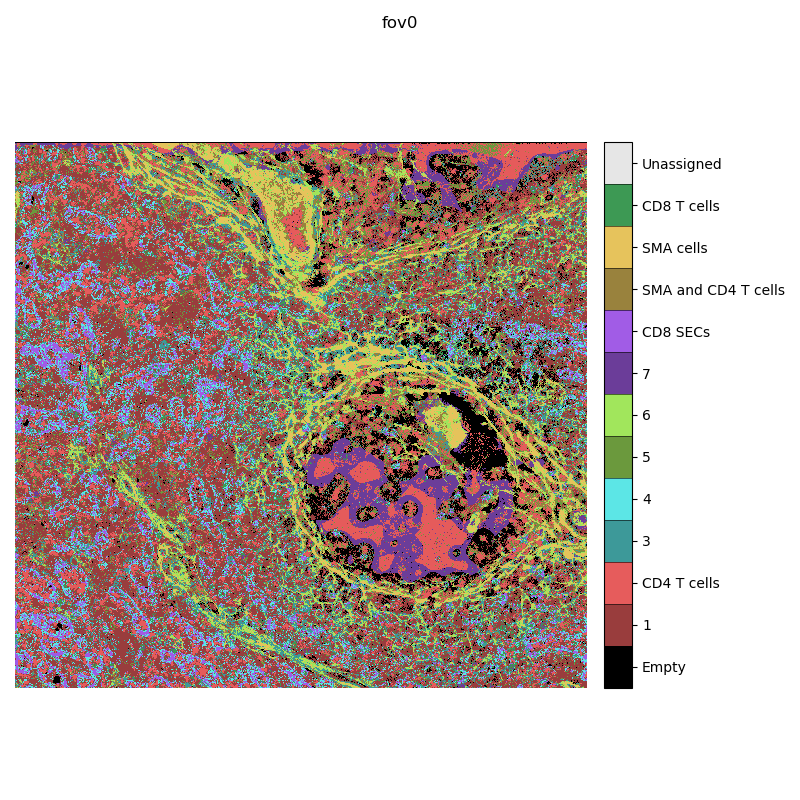

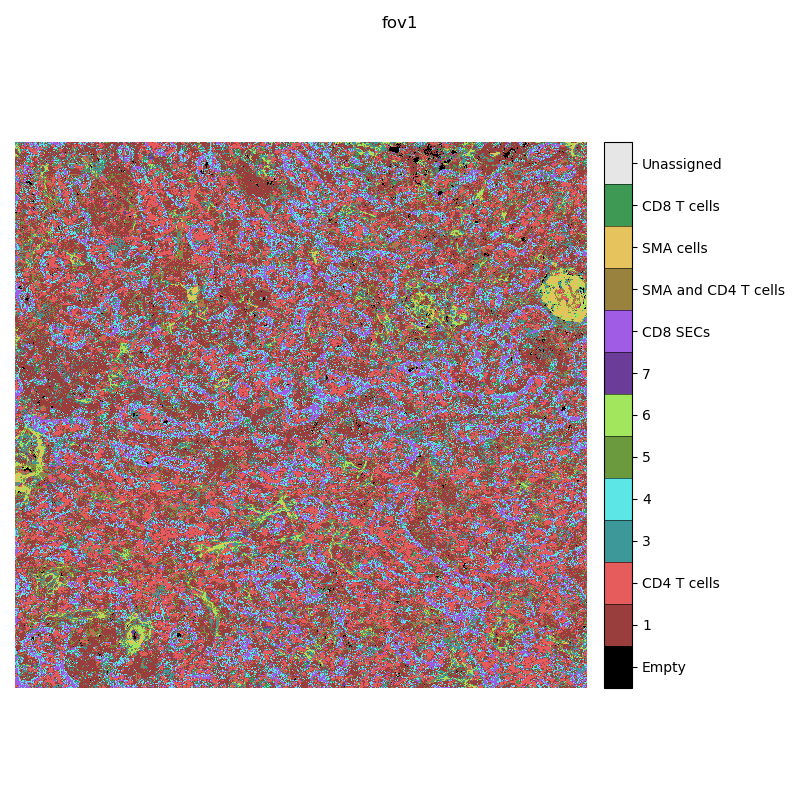

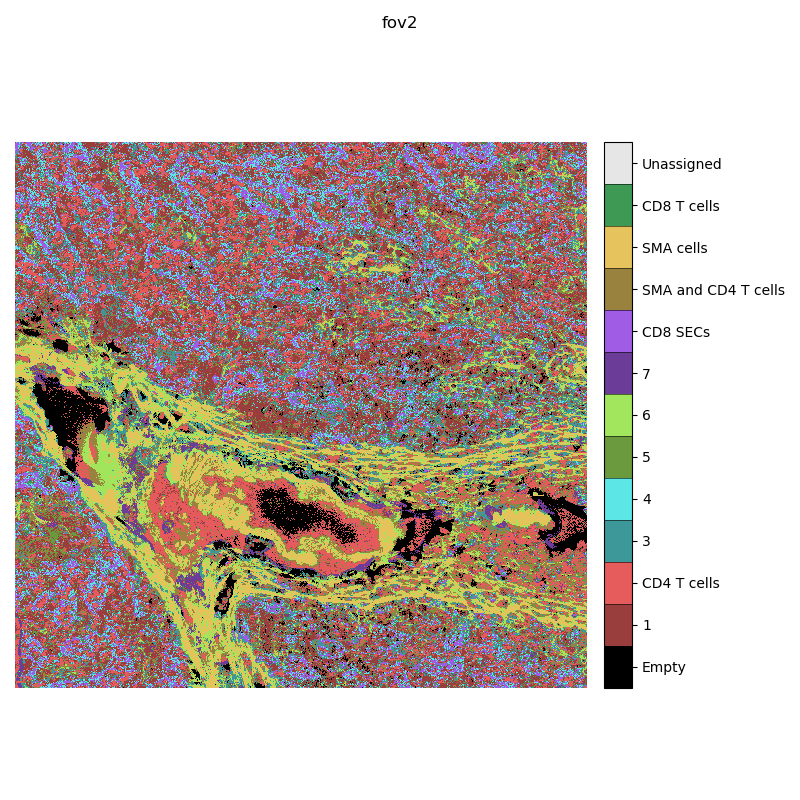

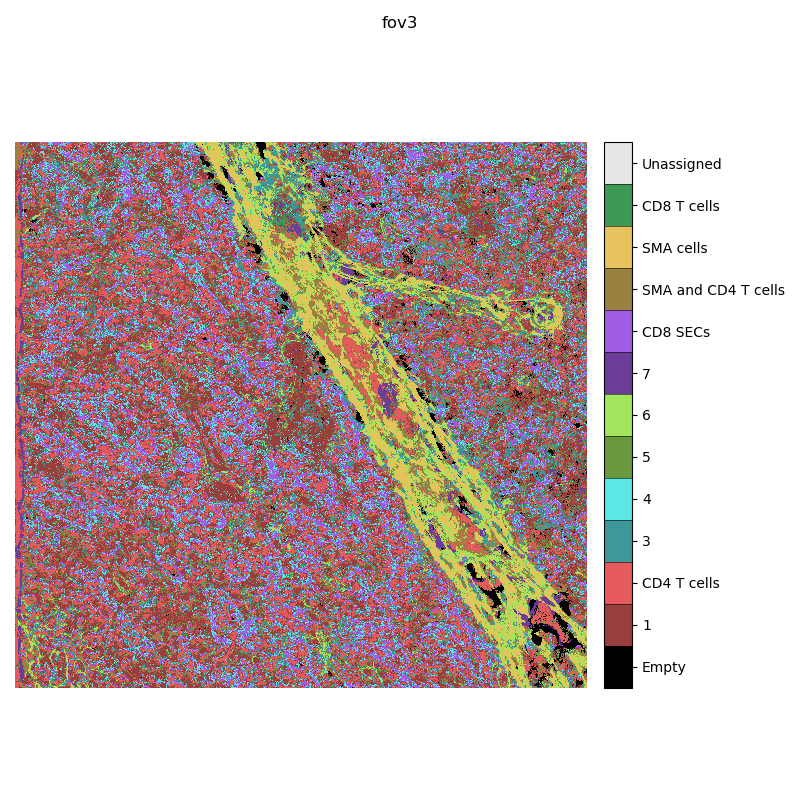

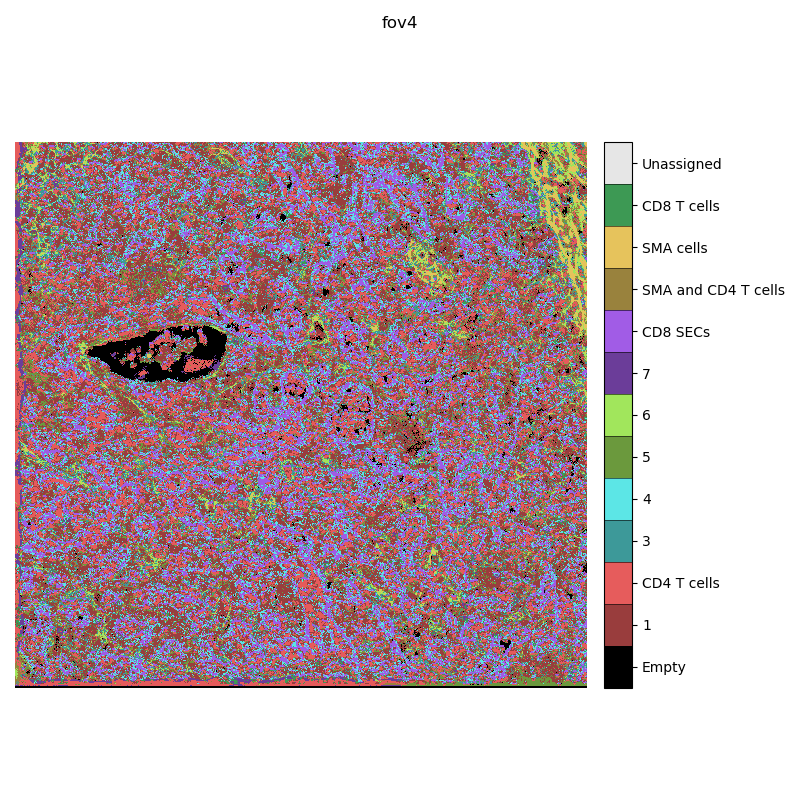

In [27]:

for pixel_fov in subset_pixel_fovs:
    pixel_cluster_mask = load_utils.load_imgs_from_dir(
        data_dir=os.path.join(base_dir, pixel_output_dir, "pixel_masks"),
        files=[pixel_fov + "_pixel_mask.tiff"],
        trim_suffix="_pixel_mask",
        match_substring="_pixel_mask",
        xr_dim_name="pixel_mask",
        xr_channel_names=None,
    )

    plot_utils.plot_pixel_cell_cluster(
        pixel_cluster_mask,
        [pixel_fov],
        os.path.join(base_dir, pixel_meta_cluster_remap_name),
        metacluster_colors=raw_cmap,
        figsize=(8, 8),
        dpi=100
    )

## 6. Save parameters for use in cell clustering and visual inspection

The following parameters are saved:

* `fovs`: fovs in `pixel_data_dir`
* `channels`: channels used for clustering
* `segmentation_dir`: path to the directory containing your segmentated images for each FOV (can be generated using `1_Segment_Image_Data.ipynb`)
* `seg_suffix`: suffix plus the file extension of the segmented images for each FOV
* `pixel_data_dir`: name of the directory containing the full pixel data with the pixel SOM and meta cluster assignments
* `pc_chan_avg_som_cluster_name`: name of the file containing the average channel expression per pixel SOM cluster
* `pc_chan_avg_meta_cluster_name`: same as above for pixel meta clusters

The file will be saved to `{pixel_cluster_prefix}_cell_clustering_params.json` and will be placed in `pixel_output_dir`. Note that the `pixel_output_dir` you use in `2_Pixie_Cluster_Pixels.ipynb` should be the same as in `3_Pixie_Cluster_Cells.ipynb`.

In [28]:
# define the params dict
cell_clustering_params = {
    'fovs': io_utils.remove_file_extensions(io_utils.list_files(os.path.join(base_dir, pixel_data_dir), substrs='.feather')),
    'channels': channels,
    'tiff_dir': tiff_dir,
    'img_sub_folder': img_sub_folder,
    'segmentation_dir': segmentation_dir,
    'seg_suffix': seg_suffix,
    'pixel_data_dir': pixel_data_dir,
    'pc_chan_avg_som_cluster_name': pc_chan_avg_som_cluster_name,
    'pc_chan_avg_meta_cluster_name': pc_chan_avg_meta_cluster_name
}

# save the params dict
with open(os.path.join(base_dir, pixel_output_dir, 'cell_clustering_params.json'), 'w') as fh:
    json.dump(cell_clustering_params, fh)

### 6.1 Save images for Mantis Viewer

Mantis Viewer is a visualization tool for multi-dimensional imaging in pathology. Learn more about Mantis Viewer https://github.com/angelolab/ark-analysis/tree/main.

In [29]:
plot_utils.create_mantis_dir(
    fovs=subset_pixel_fovs,
    mantis_project_path=os.path.join(base_dir, "mantis"),
    img_data_path=tiff_dir,
    mask_output_dir=os.path.join(base_dir, pixel_output_dir, "pixel_masks"),
    mapping = os.path.join(base_dir, pixel_meta_cluster_remap_name),
    seg_dir=pixie_seg_dir,
    mask_suffix="_pixel_mask",
    seg_suffix_name=seg_suffix)
